# Problem 1

### a) (True/False) If xt is the 0 vector, then ht = ht-1

**False**. Even though $x_t$ = 0, the transformations by Us and non-linearities make the $h_t$ = $h_{t−1}$ statement generally false. 

###  b) If f_t is very small or zero, then error will not be back-propagated to earlier time steps.

**False**. $i_t$ and $c_t$ depend on $h_{t-1}$

### c) The entries of $f_t$, $i_t$, $o_t$ are non-negative.

**True**. This is because the sigmoid has its range which is between 0 and 1 and thus the values of the above variables cannot be negative.

### d) $f_t$, $i_t$, $o_t$ can be viewed as probability distributions. (i.e., their entries are non-negative and their entries sum to 1.)

**False**. The sigmoid is applied piecewise and thus it is not necessary for the sum of this quantities to be 1. 

### e) What is the dimension of $f_t$, $i_t$, $o_t$, $h_t$.

The shapes of all of this depends on the shape of the hidden state. Since here we have the hidden state as (1,1), the dimension of each variable is (1,1)

### f) Assume the initial $h_0$, $c_0$ are both zero vectors. Calculate the output of the model $h_1$; $h_2$ 

With calculations as given in the question, the value of $h_1$= 0.21741464 and $h_2$ = 0.34940993

### g) Assume the problem we are dealing with is a regression problem. Calculate the MSE loss between current prediction and the ground truth label.

The MSE loss between the current prediction and the ground truth label will be computed as normal. 

MSE Loss = $\frac{1}{n}\Sigma_{i=0}^{n}(y_i-y_i^{-})^2$

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
import os


class FlowDataset(Dataset):
    def __init__(self, num_points=16, data_dir='flow/', data_session='all_params_50625', mode='train'):
        data_fn = os.path.join(data_dir, 'dataset_' + data_session + '.npy')
        bc_fn = os.path.join(data_dir, 'bc_'+ data_session + '.npy')
        target = np.load(data_fn)
        inputs = np.load(bc_fn)

        # Pre-Process Data
        # replace first time step with all the boundary conditions
        # for now, hardcoded to fill in since there are 4 bc's and 17 points
        for i in range(len(inputs)):
            D = inputs[i][0]
            dpdx = inputs[i][1]
            mu = inputs[i][2]
            nu = inputs[i][3]
            for j in range(num_points+1):
                if 0 <= j < 5:
                    target[i][0][j] = D
                elif 5 <= j < 9:
                    target[i][0][j] = dpdx
                elif 9 <= j < 13:
                    target[i][0][j] = mu
                else:
                    target[i][0][j] = nu

        num_data = len(inputs)
        np.random.seed(0)
        # split the dataset inton training and test 
        test_idx = np.random.choice(num_data, num_data//5, replace=False).tolist()
        train_idx = list(set(range(num_data)) - set(test_idx))

        self.mode = mode
        if mode == 'train':
            self.data = target[train_idx,:,:].astype(np.float32)
        elif mode == 'test':
            self.data = target[test_idx,:,:].astype(np.float32)
    
    def __getitem__(self, idx):
        if self.mode == 'train':
            return self.data[idx,:-1,:], self.data[idx,1:,:]
        elif self.mode == 'test':
            return self.data[idx,0,:], self.data[idx,1:,:]
    
    def __len__(self):
        return len(self.data)



In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable


class FlowLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(FlowLSTM, self).__init__()
        # build your model here
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        if self.num_layers>1:
            self.dropout = dropout
        else:
            self.dropout = 0
            
        self.lstm = nn.LSTM(
        input_size = self.input_size, hidden_size = self.hidden_size,
        num_layers = self.num_layers, batch_first=True, 
        dropout= self.dropout)      
        
        self.dense = nn.Linear(self.hidden_size, self.input_size)
        
        
        # your input should be of dim (batch_size, seq_len, input_size)
        # your output should be of dim (batch_size, seq_len, input_size) as well
        # since you are predicting velocity of next step given previous one
        
        # feel free to add functions in the class if needed


    # forward pass through LSTM layer
    def forward(self, x):
        '''
        input: x of dim (batch_size, 19, 17)
        '''
        
        batch_size,_,_ = x.shape
        hidden = (torch.zeros(self.num_layers,batch_size, self.hidden_size), 
                  torch.zeros(self.num_layers,batch_size, self.hidden_size))
        out , _ = self.lstm(x, hidden)
        out = self.dense(out)
        # define your feedforward pass
        return out
            

    # forward pass through LSTM layer for testing
    def test(self, x):
        '''
        input: x of dim (batch_size, 17)
        '''
        # define your feedforward pass
        batch_size,_ = x.shape
        hidden = (torch.zeros(self.num_layers,batch_size, self.hidden_size), 
                  torch.zeros(self.num_layers,batch_size, self.hidden_size))

        out, (h, c) = self.lstm(x[:, None, :], hidden)
        out = out[:, -1, :]
        pred = []
        for i in range(19):
            out = self.dense(out)
            pred.append(out)
            out, (h, c) = self.lstm(out[:, None, :], (h, c))
            out = out[:, -1, :]
        out = torch.stack(pred, dim=1)

        return out

In [3]:
!pip install torchsummary

Error processing line 1 of C:\Users\javal\anaconda3\lib\site-packages\matplotlib-3.6.2-py3.9-nspkg.pth:

  Traceback (most recent call last):
    File "C:\Users\javal\anaconda3\lib\site.py", line 169, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "<frozen importlib._bootstrap>", line 562, in module_from_spec
  AttributeError: 'NoneType' object has no attribute 'loader'

Remainder of file ignored


Epoch: [0/20], Batch: 199, Loss: 2.7498801500769332e-05
Epoch: [0/20], Batch: 399, Loss: 2.1169094907236286e-05
Epoch: [0/20], Batch: 599, Loss: 1.4765727428311948e-05
Epoch: [0/20], Batch: 799, Loss: 7.963497409946285e-06
Epoch: [0/20], Batch: 999, Loss: 7.133290637284517e-06
Epoch: [0/20], Batch: 1199, Loss: 5.987340500723803e-06
Epoch: [0/20], Batch: 1399, Loss: 3.9051155908964574e-06
Epoch: [0/20], Batch: 1599, Loss: 5.073571628599893e-06
Epoch: [0/20], Batch: 1799, Loss: 3.2081211429613177e-06
Epoch: [0/20], Batch: 1999, Loss: 3.2357916097680572e-06
Epoch: [0/20], Batch: 2199, Loss: 2.4627549919387093e-06
Epoch: [0/20], Batch: 2399, Loss: 2.343510232094559e-06
Epoch: [1/20], Batch: 199, Loss: 1.6007070371415466e-06
Epoch: [1/20], Batch: 399, Loss: 1.5718627537353314e-06
Epoch: [1/20], Batch: 599, Loss: 1.1144650216010632e-06
Epoch: [1/20], Batch: 799, Loss: 9.492472941019514e-07
Epoch: [1/20], Batch: 999, Loss: 9.350857226309017e-07
Epoch: [1/20], Batch: 1199, Loss: 6.752773629159

Epoch: [12/20], Batch: 599, Loss: 7.254958944713508e-08
Epoch: [12/20], Batch: 799, Loss: 6.51038760679512e-08
Epoch: [12/20], Batch: 999, Loss: 5.993443608076632e-08
Epoch: [12/20], Batch: 1199, Loss: 5.4818439565451627e-08
Epoch: [12/20], Batch: 1399, Loss: 3.398192234271846e-07
Epoch: [12/20], Batch: 1599, Loss: 5.1743349160915386e-08
Epoch: [12/20], Batch: 1799, Loss: 5.217257026401967e-08
Epoch: [12/20], Batch: 1999, Loss: 4.586451041177497e-08
Epoch: [12/20], Batch: 2199, Loss: 7.233701637687773e-08
Epoch: [12/20], Batch: 2399, Loss: 5.475140696376002e-08
Epoch: [13/20], Batch: 199, Loss: 6.4951073852626e-08
Epoch: [13/20], Batch: 399, Loss: 8.598917844437892e-08
Epoch: [13/20], Batch: 599, Loss: 1.0101896918968123e-07
Epoch: [13/20], Batch: 799, Loss: 1.310110064878245e-07
Epoch: [13/20], Batch: 999, Loss: 8.004237628256305e-08
Epoch: [13/20], Batch: 1199, Loss: 1.1025768742456421e-07
Epoch: [13/20], Batch: 1399, Loss: 1.221584540189724e-07
Epoch: [13/20], Batch: 1599, Loss: 4.2

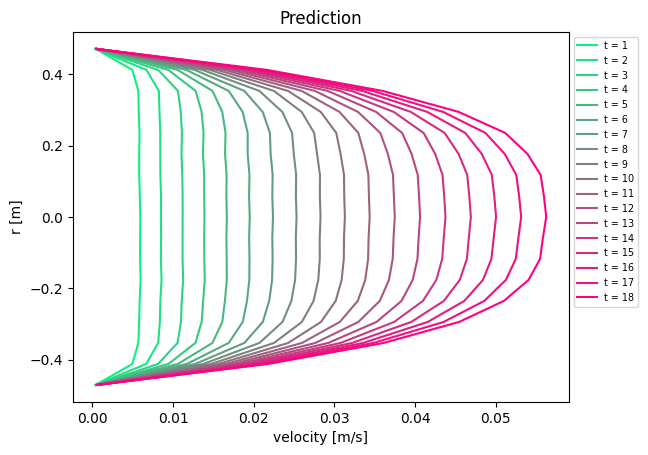

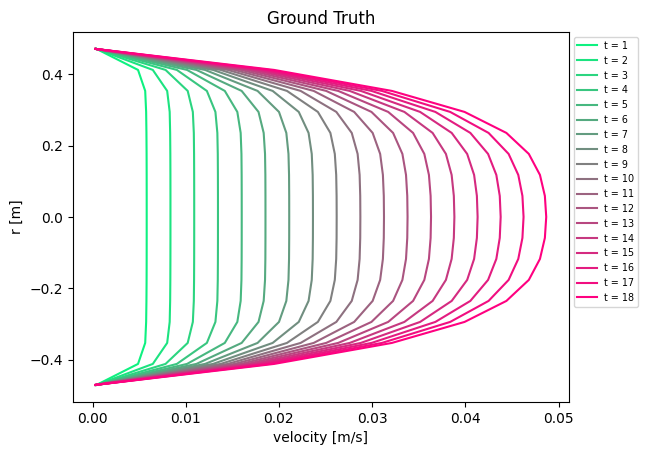

In [4]:
import os
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from dataset import FlowDataset
from lstm import FlowLSTM


def main():
    # check if cuda available
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

    # define dataset and dataloader
    train_dataset = FlowDataset(mode='train')
    test_dataset = FlowDataset(mode='test')
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=16, 
                              shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset=test_dataset, batch_size=16, 
                             shuffle=False, num_workers=4)

    # hyper-parameters
    num_epochs = 20 
    lr = 0.001
    input_size = 17 # do not change input size
    hidden_size = 30 
    num_layers = 2
    dropout = 0.1

    model = FlowLSTM(
        input_size=input_size, 
        hidden_size=hidden_size, 
        num_layers=num_layers, 
        dropout=dropout
    ).to(device)

    # define your LSTM loss function here
    loss_func = nn.MSELoss()

    # define optimizer for lstm model
    optim = Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        for n_batch, (in_batch, label) in enumerate(train_loader):
            in_batch, label = in_batch.to(device), label.to(device)

           # train LSTM
            outputs = model(in_batch)

            # calculate LSTM loss
            loss = loss_func(outputs, label)

            optim.zero_grad()
            loss.backward()
            optim.step()

            # print loss while training

            if (n_batch + 1) % 200 == 0:
                print("Epoch: [{}/{}], Batch: {}, Loss: {}".format(
                    epoch, num_epochs, n_batch, loss.item()))

    # test trained LSTM model
    l1_err, l2_err = 0, 0
    l1_loss = nn.L1Loss()
    l2_loss = nn.MSELoss()
    model.eval()
    with torch.no_grad():
        for n_batch, (in_batch, label) in enumerate(test_loader):
            in_batch, label = in_batch.to(device), label.to(device)
            pred = model.test(in_batch)

            l1_err += l1_loss(pred, label).item()
            l2_err += l2_loss(pred, label).item()

    print("Test L1 error:", l1_err)
    print("Test L2 error:", l2_err)

    # visualize the prediction comparing to the ground truth
    if device == 'cpu':
        pred = pred.detach().numpy()[0,:,:]
        label = label.detach().numpy()[0,:,:]
    else:
        pred = pred.detach().cpu().numpy()[0,:,:]
        label = label.detach().cpu().numpy()[0,:,:]

    r = []
    num_points = 17
    interval = 1./num_points
    x = int(num_points/2)
    for j in range(-x,x+1):
        r.append(interval*j)

    from matplotlib import pyplot as plt
    plt.figure()
    for i in range(1, len(pred)):
        c = (i/(num_points+1), 1-i/(num_points+1), 0.5)
        plt.plot(pred[i], r, label='t = %s' %(i), c=c)
    plt.xlabel('velocity [m/s]')
    plt.ylabel('r [m]')
    plt.title('Prediction')
    plt.legend(bbox_to_anchor=(1,1),fontsize='x-small')
    plt.show()

    plt.figure()
    for i in range(1, len(label)):
        c = (i/(num_points+1), 1-i/(num_points+1), 0.5)
        plt.plot(label[i], r, label='t = %s' %(i), c=c)
    plt.xlabel('velocity [m/s]')
    plt.ylabel('r [m]')
    plt.title('Ground Truth')
    plt.legend(bbox_to_anchor=(1,1),fontsize='x-small')
    plt.show()


if __name__ == "__main__":
    main()